In [37]:
import numpy as np
import matplotlib.pyplot as plt
import tqdm

In [38]:
VALUES = np.zeros(7)
VALUES[1:6] = 0.5
VALUES[6] = 1

# set up true state values
TRUE_VALUE = np.zeros(7)
TRUE_VALUE[1:6] = np.arange(1, 6) / 6.0
TRUE_VALUE[6] = 1

ACTION_LEFT = 0
ACTION_RIGHT = 1

In [39]:
# @values: current states value, will be updated if @batch is False
# @alpha: step size
# @batch: whether to update @values
def temporal_difference(values, alpha=0.1, batch=False):
    state = 3
    trajectory = [state]
    rewards = [0]
    while True:
        old_state = state
        if np.random.choice(2) == ACTION_LEFT:
            state -= 1
        else:
            state += 1
        # Assume all rewards are 0
        reward = 0
        trajectory.append(state)
        # TD update
        if not batch:
            values[old_state] += alpha * (reward + values[state] - values[old_state])
        if state == 6 or state == 0:
            break
        rewards.append(reward)
    return trajectory, rewards

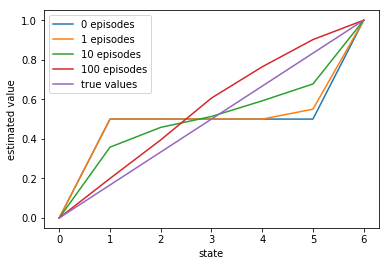

In [40]:
episodes = [0, 1, 10, 100]
current_values = np.copy(VALUES)
plt.figure(1)
for i in range(episodes[-1] + 1):
    if i in episodes:
        plt.plot(current_values, label=str(i) + ' episodes')
    temporal_difference(current_values)
plt.plot(TRUE_VALUE, label='true values')
plt.xlabel('state')
plt.ylabel('estimated value')
plt.legend()

In [41]:
# chapter 9, value approximation, state = 1000

In [42]:
N_STATES = 1000

# all states
STATES = np.arange(1, N_STATES + 1)

# start from a central state
START_STATE = 500

# terminal states
END_STATES = [0, N_STATES + 1]

# possible actions
ACTION_LEFT = -1
ACTION_RIGHT = 1
ACTIONS = [ACTION_LEFT, ACTION_RIGHT]

# maximum stride for an action
STEP_RANGE = 100

In [43]:
def compute_true_value():
    # true state value, just a promising guess
    true_value = np.arange(-1001, 1003, 2) / 1001.0

    # Dynamic programming to find the true state values, based on the promising guess above
    # Assume all rewards are 0, given that we have already given value -1 and 1 to terminal states
    while True:
        old_value = np.copy(true_value)
        for state in STATES:
            true_value[state] = 0
            for action in ACTIONS:
                for step in range(1, STEP_RANGE + 1):
                    step *= action
                    next_state = state + step
                    next_state = max(min(next_state, N_STATES + 1), 0)
                    # asynchronous update for faster convergence
                    true_value[state] += 1.0 / (2 * STEP_RANGE) * true_value[next_state]
        error = np.sum(np.abs(old_value - true_value))
        if error < 1e-2:
            break
    # correct the state value for terminal states to 0
    true_value[0] = true_value[-1] = 0

    return true_value

In [44]:
# take an @action at @state, return new state and reward for this transition
def step(state, action):
    step = np.random.randint(1, STEP_RANGE + 1)
    step *= action
    state += step
    state = max(min(state, N_STATES + 1), 0)
    if state == 0:
        reward = -1
    elif state == N_STATES + 1:
        reward = 1
    else:
        reward = 0
    return state, reward

In [45]:
# get an action, following random policy
def get_action():
    if np.random.choice(2) == 1:
        return 1
    return -1

In [46]:
# a wrapper class for aggregation value function
class ValueFunction:
    # @num_of_groups: # of aggregations
    def __init__(self, num_of_groups):
        self.num_of_groups = num_of_groups
        self.group_size = N_STATES // num_of_groups

        # thetas
        self.params = np.zeros(num_of_groups)

    # get the value of @state
    def value(self, state):
        if state in END_STATES:
            return 0
        group_index = (state - 1) // self.group_size
        return self.params[group_index]

    # update parameters
    # @delta: step size * (target - old estimation)
    # @state: state of current sample
    def update(self, delta, state):
        group_index = (state - 1) // self.group_size
        self.params[group_index] += delta

In [47]:
def gradient_monte_carlo(value_function, alpha, distribution=None):
    state = START_STATE
    trajectory = [state]

    # We assume gamma = 1, so return is just the same as the latest reward
    reward = 0.0
    while state not in END_STATES:
        action = get_action()
        next_state, reward = step(state, action)
        trajectory.append(next_state)
        state = next_state

    # Gradient update for each state in this trajectory
    for state in trajectory[:-1]:
        delta = alpha * (reward - value_function.value(state))
        value_function.update(delta, state)
        if distribution is not None:
            distribution[state] += 1


In [50]:
def figure_9_1(true_value):
    episodes = int(1e5)
    alpha = 2e-5

    # we have 10 aggregations in this example, each has 100 states
    value_function = ValueFunction(10)
    distribution = np.zeros(N_STATES + 2)
    #for ep in tqdm(range(episodes)):
    for ep in range(episodes):
        gradient_monte_carlo(value_function, alpha, distribution)

    distribution /= np.sum(distribution)
    state_values = [value_function.value(i) for i in STATES]

    plt.figure(figsize=(10, 20))

    plt.subplot(2, 1, 1)
    plt.plot(STATES, state_values, label='Approximate MC value')
    plt.plot(STATES, true_value[1: -1], label='True value')
    plt.xlabel('State')
    plt.ylabel('Value')
    plt.legend()

    plt.subplot(2, 1, 2)
    plt.plot(STATES, distribution[1: -1], label='State distribution')
    plt.xlabel('State')
    plt.ylabel('Distribution')
    plt.legend()


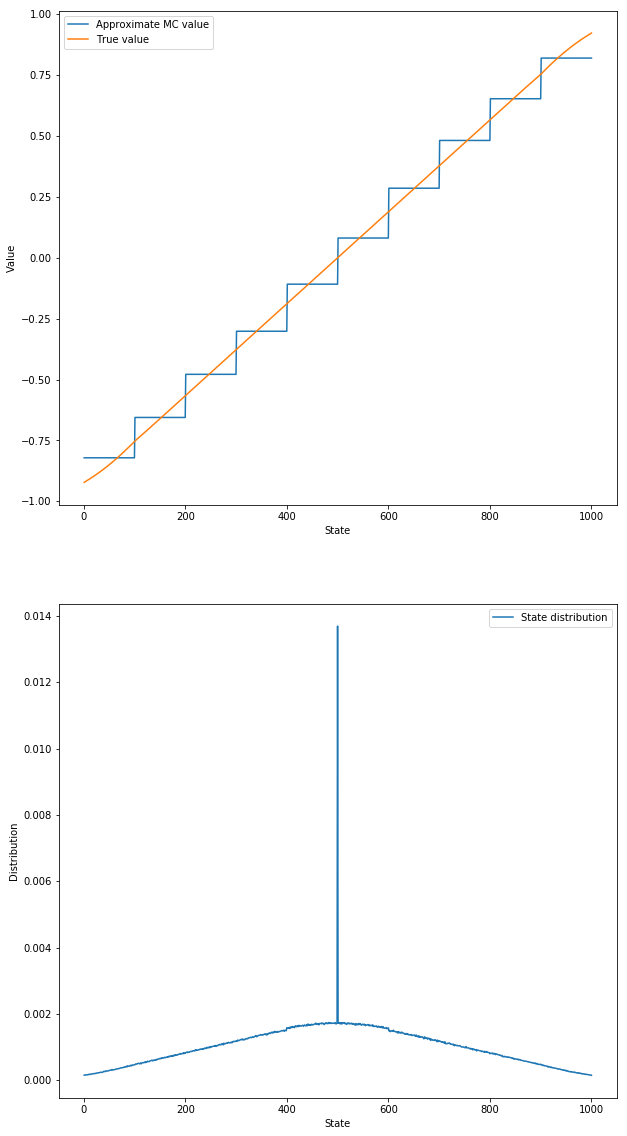

In [51]:
true_value = compute_true_value()
figure_9_1(true_value)